In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = kagglehub.dataset_download("prokshitha/home-value-insights")
houses = pd.read_csv(path + '/house_price_regression_dataset.csv')

In [ ]:
houses

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06
...,...,...,...,...,...,...,...,...
995,3261,4,1,1978,2.165110,2,10,7.014940e+05
996,3179,1,2,1999,2.977123,1,10,6.837232e+05
997,2606,4,2,1962,4.055067,0,2,5.720240e+05
998,4723,5,2,1950,1.930921,0,7,9.648653e+05


In [ ]:
houses.isna().sum()
columns = houses.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
houses = sc.fit_transform(houses)

In [ ]:
houses=pd.DataFrame(data=houses, columns=columns)
X = houses.drop('House_Price', axis=1)
y = houses['House_Price']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print("Coefficients:", model.coef_)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Coefficients: [0.98786834 0.05756691 0.02655555 0.08084444 0.07619172 0.01653982
 0.00131014]
Mean Squared Error: 0.001579182753220838
R-squared Score: 0.9984263636823413


In [ ]:
## Verificare pe setul de train
y_pred_train = model.predict(x_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Mean Squared Error:", mse_train)
print("R-squared Score:", r2_train)

Mean Squared Error: 0.0014611074663622554
R-squared Score: 0.9985375946918145


In [ ]:
residuals = y_test - y_pred

In [ ]:
residuals

,House_Price
521,0.127499
737,0.016570
740,0.014745
660,0.027565
411,0.068305
...,...
408,0.024458
332,0.052119
208,-0.035980
613,-0.027184


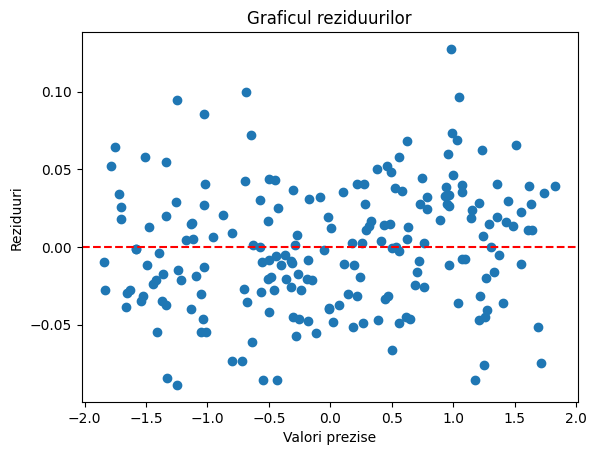

In [ ]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valori prezise")
plt.ylabel("Reziduuri")
plt.title("Graficul reziduurilor")
plt.show()

In [ ]:
np.mean(residuals)

-0.00046922023265312583

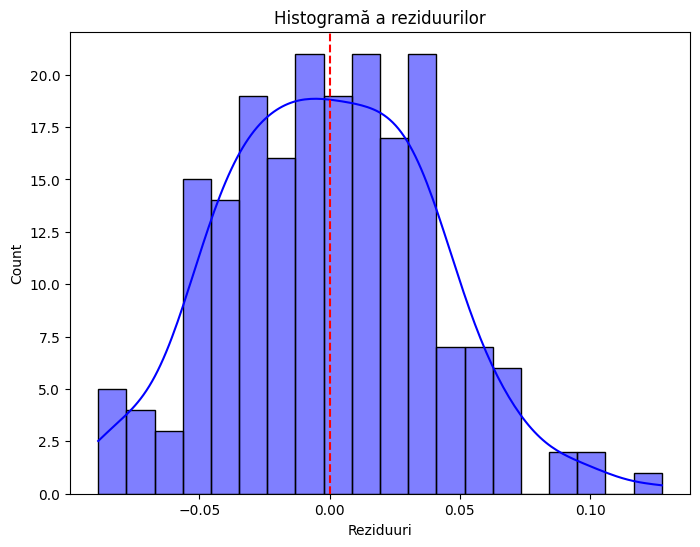

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=20, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Reziduuri")
plt.title("Histogramă a reziduurilor")
plt.show()

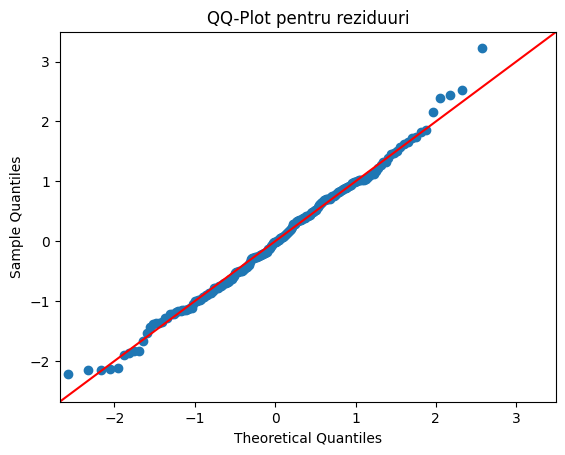

In [ ]:
import statsmodels.api as sm
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ-Plot pentru reziduuri")
plt.show()

## Caracteristicile reziduurilor ideale
* Media reziduurilor sa fie aproape de 0
* Reziduurile sunt distribuite aleator in jurul valorii 0
* Reziduurile ar trebui sa urmeze o distributie normala
* Dacă reziduurile sunt distribuite normal, punctele se aliniază aproape perfect pe linia diagonală (linie 45°), iar la capetele graficului QQ-Plot (extremele distribuției), punctele nu ar trebui să se îndepărteze semnificativ de linie.

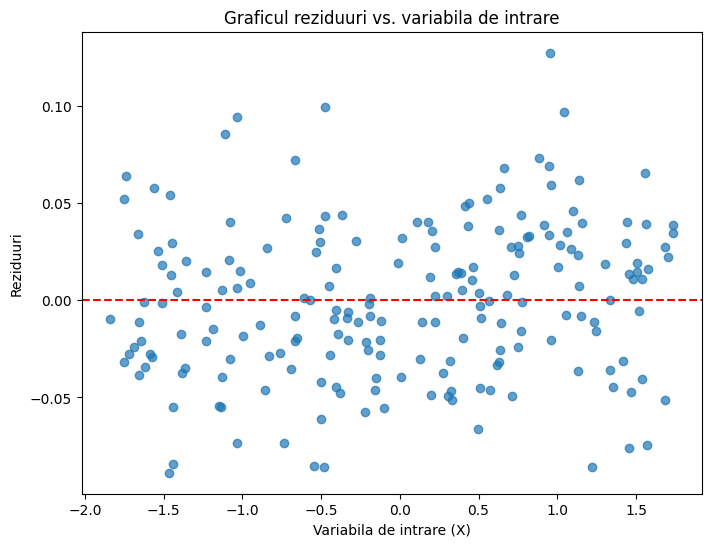

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_test.Square_Footage, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Variabila de intrare (X)")
plt.ylabel("Reziduuri")
plt.title("Graficul reziduuri vs. variabila de intrare")
plt.show()

In [ ]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={stat:.3f}, p-value={p_value:.3f}")
if p_value > 0.05:
    print("Reziduuri distribuite normal.")
else:
    print("Reziduuri NU sunt distribuite normal.")

Shapiro-Wilk test: statistic=0.993, p-value=0.467
Reziduuri distribuite normal.


In [ ]:
from scipy.stats import t

# Calculul erorii standard (simplificat pentru demonstrație)
X_train_const = sm.add_constant(x_train)
predictions = model.predict(x_train)
residuals = y_train - predictions
rss = np.sum(residuals**2)  # Suma pătratelor reziduurilor
n, k = X_train_const.shape  # n: nr. de observații, k: nr. de coeficienți
sigma_squared = rss / (n - k)  # Varianța reziduurilor
cov_matrix = np.linalg.inv(X_train_const.T @ X_train_const) * sigma_squared
std_err = np.sqrt(np.diag(cov_matrix))  # Erorile standard

# t-statistic și p-values
t_stats = model.coef_ / std_err[1:]  # Excludem interceptul
p_values = [2 * (1 - t.cdf(np.abs(t_stat), df=n - k)) for t_stat in t_stats]

print("t-statistic:", t_stats)
print("p-values:", p_values)

t-statistic: [717.77695029  41.76122487  19.37388115  59.8656568   54.87693319
  12.12281961   0.97169346]
p-values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33149973373894603]
